## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from time import time
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Face Recognition

## Load Data

❓ Run the cell below to download a copy of the famous LFW dataset provided by `Sklearn`.

Once downloaded, unzip the downloaded file into a `data` folder. It should look like this:

```bash
data
└── lfw_home
    ├── joblib
    ├── lfw
    ├── pairs.txt
    ├── pairsDevTest.txt
    └── pairsDevTrain.txt
```

*Hint:* to reach the file more quickly for unzipping, you can right-click it and click on "Reveal in Finder" ("File Explorer" for Windows, "File Manager" for Ubuntu).

In [2]:
# # Download data, should take around 2min
# !curl https://wagon-public-datasets.s3-eu-west-1.amazonaws.com/05-Machine-Learning/06-Unsupervised-Learning/face_recognition/data.zip > data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0  191M    0 51645    0     0  36723      0  1:31:21  0:00:01  1:31:20 36810
  1  191M    1 2353k    0     0   986k      0  0:03:19  0:00:02  0:03:17  987k
  2  191M    2 4444k    0     0  1308k      0  0:02:30  0:00:03  0:02:27 1310k
  3  191M    3 6552k    0     0  1493k      0  0:02:11  0:00:04  0:02:07 1495k
  4  191M    4 8282k    0     0  1530k      0  0:02:08  0:00:05  0:02:03 1891k
  5  191M    5 9834k    0     0  1540k      0  0:02:07  0:00:06  0:02:01 1964k
  6  191M    6 11.6M    0     0  1610k      0  0:02:02  0:00:07  0:01:55 1909k
  6  191M    6 13.3M    0     0  1626k      0  0:02:00  0:00:08  0:01:52 1842k
  7  191M    7 15.1M    0     0  1644k      0  0:01

In [3]:
# from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(data_home='data', min_faces_per_person=70, resize=0.4, funneled=False)

💡 The **faces** object contains the following:
- `faces.images`: images as matrices of **50 x 37 pixels** you can plot 
- `faces.data`: flattened version of size **1850 x 1** *(50 x 37=1850)* 
- `faces.target`: number index representing a class among 7

❓ Run the cells below to check some basic facts about your data and see some images

In [4]:
print(f"- Images shape: {faces.images.shape}")
print(f"- Data (flattened images) shape: {faces.data.shape}")
print(f"- Target shape: {faces.target.shape}")
print(f"- Number of classes: {np.unique(faces.target).shape}")
print(f"- Each class is a famous person: {', '.join(faces.target_names)}")

- Images shape: (1288, 50, 37)
- Data (flattened images) shape: (1288, 1850)
- Target shape: (1288,)
- Number of classes: (7,)
- Each class is a famous person: Ariel Sharon, Colin Powell, Donald Rumsfeld, George W Bush, Gerhard Schroeder, Hugo Chavez, Tony Blair


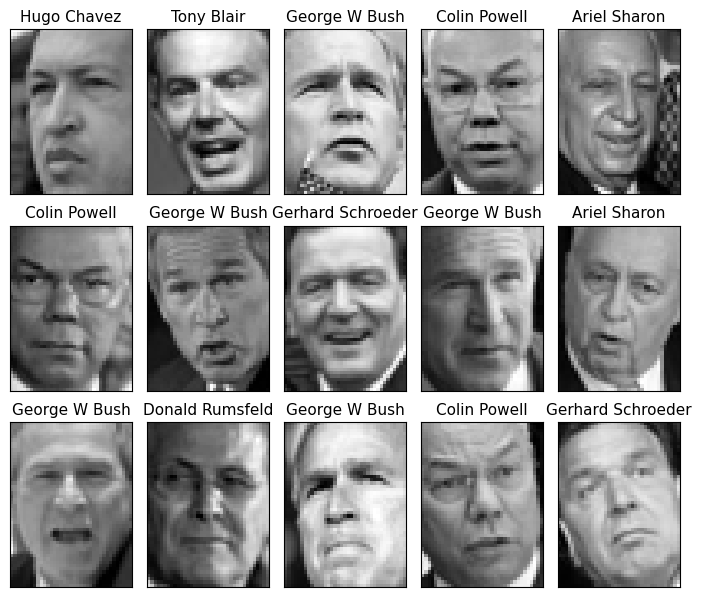

In [5]:
fig = plt.figure(figsize=(7,10))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.title(faces.target_names[faces.target[i]], size=11)
    plt.imshow(faces.images[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()

**Disclaimer**: we are aware that this dataset is not diverse at all and we apologize in advance. However, it is very well suited to understand PCA (low pixel count, B&W, only a few categories, faces well centered in the pictures, etc.) so please keep moving forward in this challenge to understand the notion of "principal component"!

## 2) Compression with PCA

In [6]:
pca = PCA(n_components=150).fit(faces.data)
pca

PCA(n_components=150)

In [7]:
data_projected = pd.DataFrame(pca.transform(faces.data))
data_projected

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-1.619428,-1.507730,-0.037036,-0.357536,-0.483413,0.401034,-0.206893,0.894975,-0.271271,-0.212930,...,-0.010945,-0.437554,-0.110568,0.033983,-0.233376,-0.197830,-0.042355,-0.064914,-0.353076,-0.037923
1,2.160853,-3.241604,0.606053,0.876692,1.176245,-2.169051,-0.063054,1.268050,-0.021298,1.990511,...,-0.221913,-0.140069,0.313585,-0.126272,-0.003370,-0.232863,-0.187893,0.110420,0.000678,0.052564
2,-2.572261,-0.457799,-1.035993,-1.249724,0.264295,-0.127726,-0.411198,-1.043921,-0.420282,1.483854,...,0.206444,0.086660,-0.100770,0.129795,0.110394,0.005322,-0.251708,0.183777,0.046939,0.146746
3,0.441712,-2.345074,-0.197760,-2.339198,1.574509,0.724245,0.014996,1.450707,-0.659763,-0.763941,...,-0.102058,-0.198607,-0.059591,-0.083609,0.015585,0.103904,0.138479,-0.008322,-0.171552,-0.014820
4,4.013384,1.930254,2.679564,-0.628568,-0.274245,1.560862,-0.724098,-0.586559,-1.056079,-0.480919,...,0.251229,0.367610,0.032730,0.218743,-0.377655,0.114605,0.080417,0.129053,-0.350032,-0.262603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,-2.575238,-3.829735,-3.750360,2.063997,0.719955,-2.036755,0.088317,0.810859,-1.078327,0.758947,...,0.015418,-0.170469,-0.022235,0.146516,-0.109535,0.187296,0.161413,0.130464,0.336451,-0.156376
1284,1.533732,-1.680000,-3.250760,-2.547065,-2.857016,0.128607,0.179222,-1.407637,0.756005,1.072945,...,0.197290,-0.110951,-0.010657,0.170881,-0.132330,0.363603,0.103671,0.170264,-0.211636,0.123997
1285,3.755537,0.879406,0.335873,-0.779273,-0.746046,-0.830231,-0.603166,1.094075,-0.136574,0.829346,...,0.098370,-0.166762,0.030840,0.104413,0.022693,-0.226923,-0.084805,0.139782,0.219613,0.062038
1286,-3.708679,-0.507192,1.473879,1.620680,-0.361707,1.695732,1.409575,-0.583053,0.427692,-0.458241,...,0.400958,0.057600,-0.096077,-0.082408,0.083926,-0.012894,-0.036649,-0.060519,-0.165712,-0.000998


The images were projected onto the first 150 principal components only. 

Again, what we call components are **directions of maximum variance** of the data. 

Now, we don't need 1850 pixels anymore to describe each image, but only 150 values 🤓  

A gain by factor of $\frac{1850}{150} = 12$ 🚀  

❓ Look at the shape of your components, and make sure you understand what it represents  
❓ Look at the shape of your first component, again make sure you understand what it represents  

In [8]:
data_projected[0].shape

(1288,)

Your first component is a vector of 1850 values.  
We now have 150 components of 1850 values each.

One face is described as a linear combination of those components.

Let's reconstruct one image from its reduced representation to see how it works.

❓ Use `inverse_transform` on your **data_projected** to reconstruct your compressed images  
👉 Store the result in **data_reconstructed**

In [9]:
data_reconstructed = pca.inverse_transform(data_projected)
data_reconstructed

array([[ 0.95214176,  0.937759  ,  0.88537025, ...,  0.45160133,
         0.44676363,  0.45162377],
       [ 0.26631403,  0.23567544,  0.16497603, ...,  0.3274648 ,
         0.39623532,  0.42921364],
       [ 0.42234054,  0.4800411 ,  0.53173584, ...,  0.6710889 ,
         0.69001746,  0.72854316],
       ...,
       [ 0.41288918,  0.41144013,  0.35396373, ...,  0.1751956 ,
         0.18613623,  0.14934012],
       [ 0.2964374 ,  0.24599321,  0.26501033, ...,  0.24985576,
         0.06890434, -0.00744176],
       [ 0.3565776 ,  0.26425454,  0.19417194, ...,  0.13115564,
         0.2037608 ,  0.27860034]], dtype=float32)

❓ Plot the 13th picture (George W. Bush) of the reconstructed dataset, and compare it with the original one. 

<details>

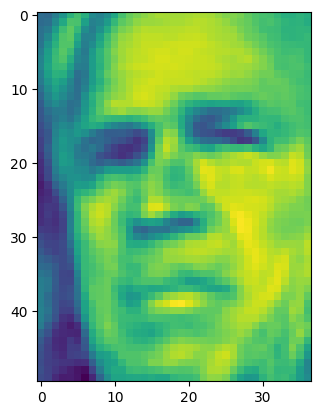

In [10]:
plt.imshow(data_reconstructed[12].reshape(50, 37));

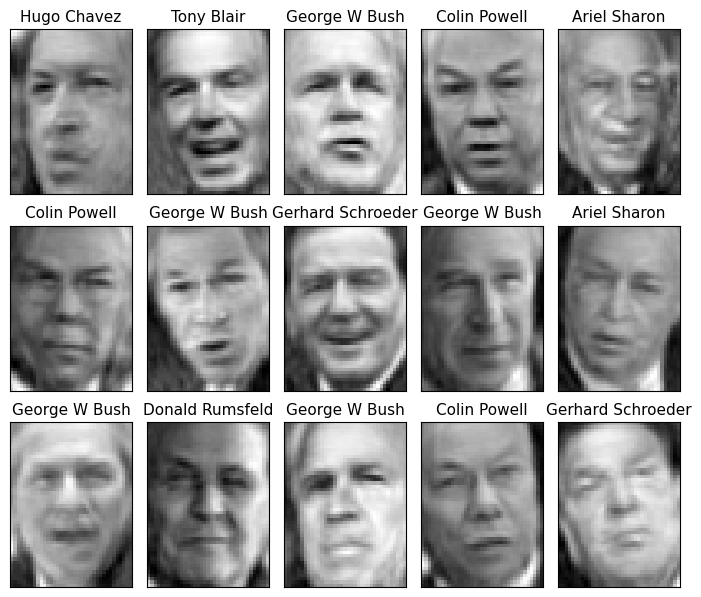

In [11]:
fig = plt.figure(figsize=(7, 10))
for i in range(15):
    plt.subplot(5, 5, i + 1)

    # Display each image with a title, which we grab from the dataset
    plt.title(faces.target_names[faces.target[i]], size=11)
    plt.imshow(pca.inverse_transform(data_projected)[i].reshape((50,37)), cmap=plt.cm.gray)

    # Remove plot ticks
    plt.xticks(())
    plt.yticks(())
    
plt.tight_layout()

## Investigate your Principal Components

❓ Plot an image that corresponds to the *\"mean\"* face of the whole dataset  
👉 Use a `gray` color map for your plots in this section

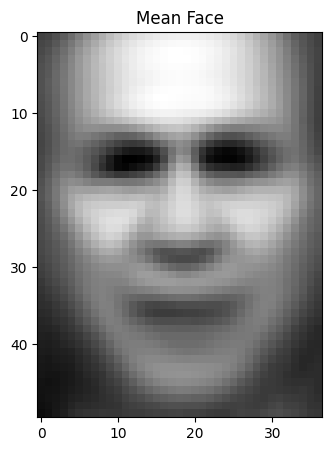

In [12]:
pca5 = PCA(n_components=5).fit(faces.data)
mean_face = pca5.mean_.reshape(50, 37)
plt.figure(figsize=(5, 5))
plt.imshow(mean_face, cmap="gray")
plt.title("Mean Face")
plt.show()

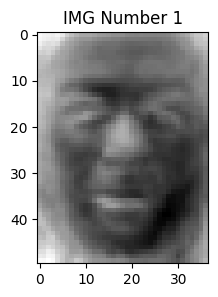

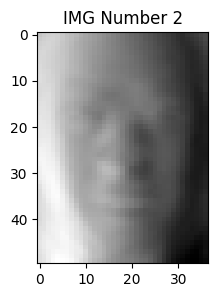

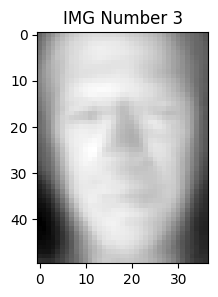

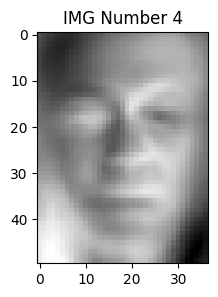

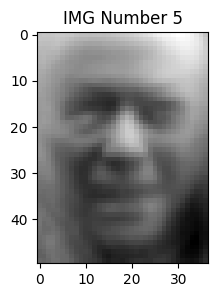

In [13]:
for i, component in enumerate(pca5.components_):
    component_img = component.reshape(50, 37)
    plt.figure(figsize=(16, 3))
    plt.imshow(component_img,cmap="gray")
    plt.title(f"IMG Number {i + 1}")
    plt.show()

❓ Plot the images corresponding to the **first 5** principal components  

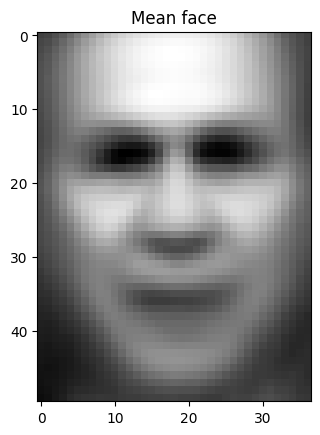

In [14]:
plt.title("Mean face")
plt.imshow(pca.mean_.reshape(50,37), cmap="gray");

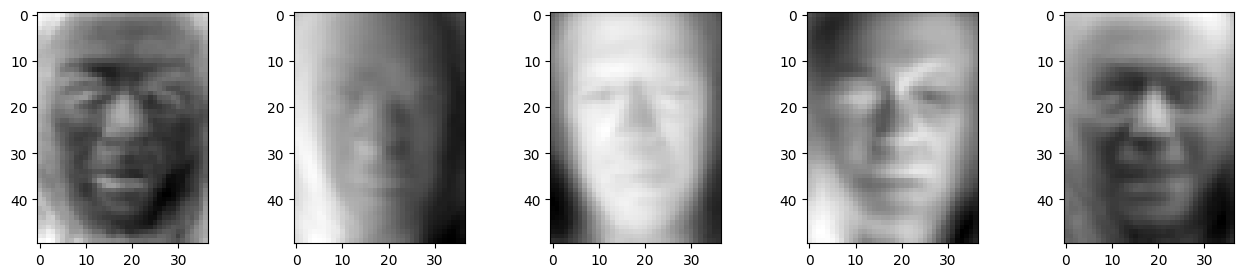

In [15]:
fig, axs = plt.subplots(1, 5, figsize=(16, 3))
axs[0].imshow(pca.components_[0].reshape(50,37), cmap="gray" );
axs[1].imshow(pca.components_[1].reshape(50,37), cmap="gray" );
axs[2].imshow(pca.components_[2].reshape(50,37), cmap="gray" );
axs[3].imshow(pca.components_[3].reshape(50,37), cmap="gray" );
axs[4].imshow(pca.components_[4].reshape(50,37), cmap="gray" );

☝️ Each PC is a flattened "image" of 1850 pixels  
We merely reshaped them to be able to visualize them as normal images

👇 Below is a list of definitions of these Principal Components  

❓ **Read them carefully and make sure you understand them**, otherwise consider raising a ticket 🎟️ 

💡 Your first PCs are the **most important _directions_** on your 1850-feature observations

💡 They are the most important **_linear combinations_** of your 1850 pixels

💡 The ones which **preserve the most _variance_** when your dataset of pictures is projected onto them  

💡 The first few PCs are the **regions of the 2D pixel grid that contain the _most variation_** between your 1288 images

❓ Plot the images corresponding to the **last 5** principal components  

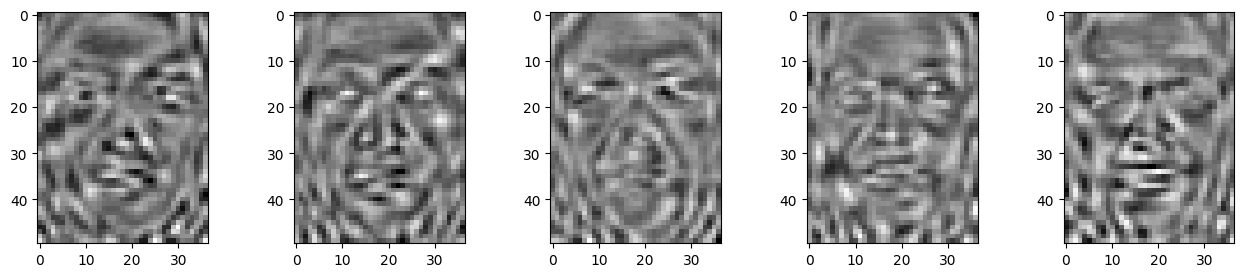

In [16]:
# YOUR CODE HERE
fig, axs = plt.subplots(1, 5, figsize=(16, 3))
axs[0].imshow(pca.components_[-1].reshape(50,37), cmap="gray" );
axs[1].imshow(pca.components_[-2].reshape(50,37), cmap="gray" );
axs[2].imshow(pca.components_[-3].reshape(50,37), cmap="gray" );
axs[3].imshow(pca.components_[-4].reshape(50,37), cmap="gray" );
axs[4].imshow(pca.components_[-5].reshape(50,37), cmap="gray" );

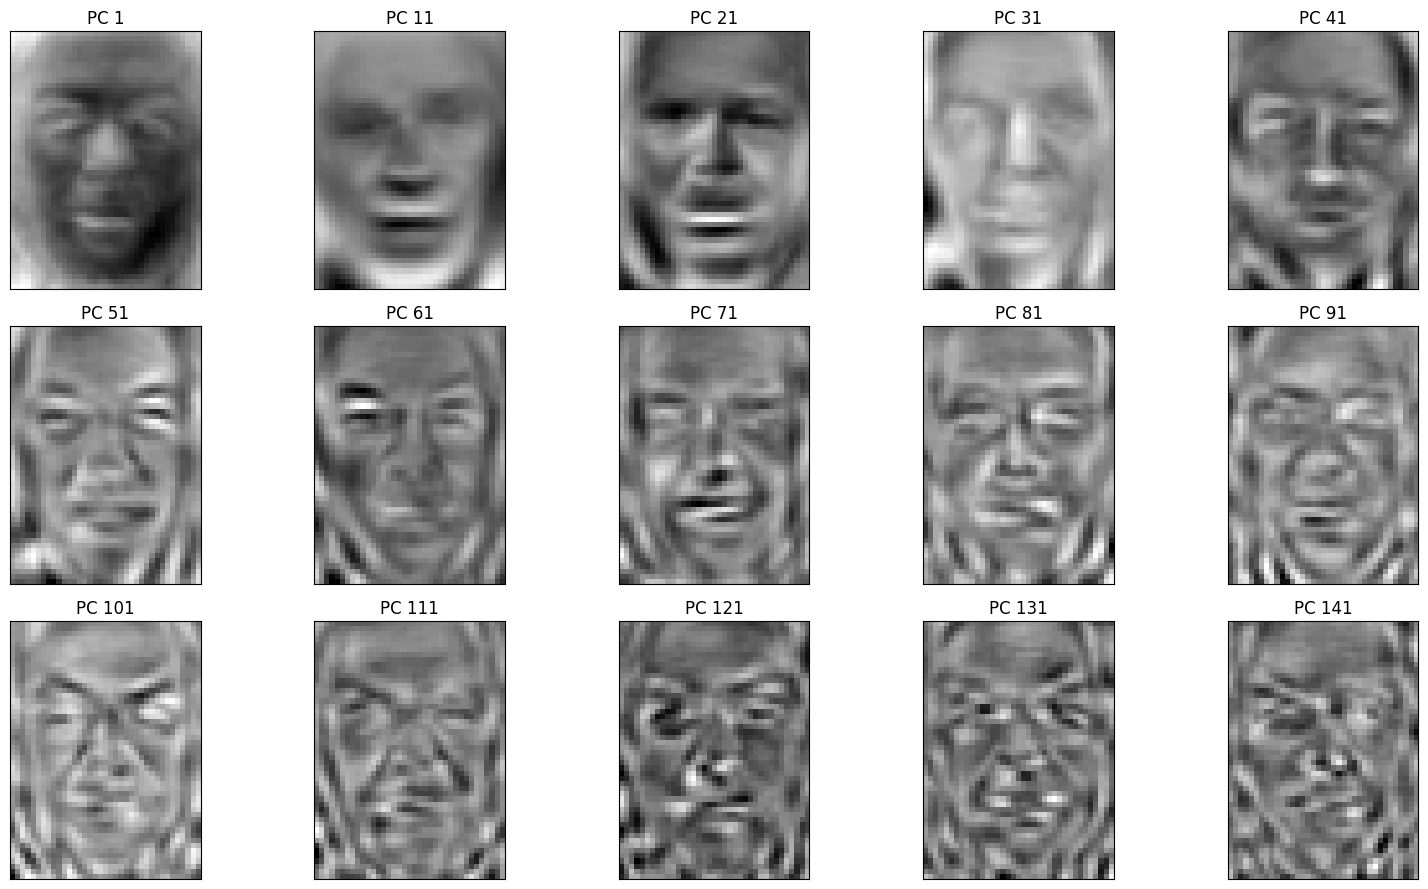

In [17]:
n_rows, n_cols = 3, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 9))

for i in range(n_rows * n_cols):
    ax = axs[i // n_cols, i % n_cols]
    ax.set_title(f'PC {i * 10 + 1}', size=12)
    ax.set_xticks(()), ax.set_yticks(())
    ax.imshow(pca.components_[i * 10].reshape(50, 37), cmap='gray')

plt.tight_layout()

## Choose the Optimal Number of Components

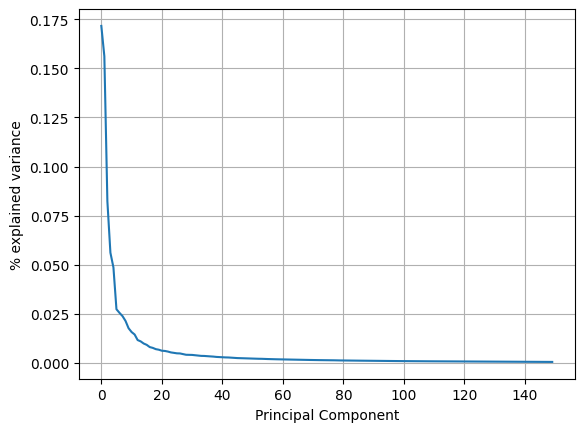

In [18]:
plt.plot(pca.explained_variance_ratio_)
plt.grid(True)
plt.xlabel("Principal Component"); plt.ylabel("% explained variance");

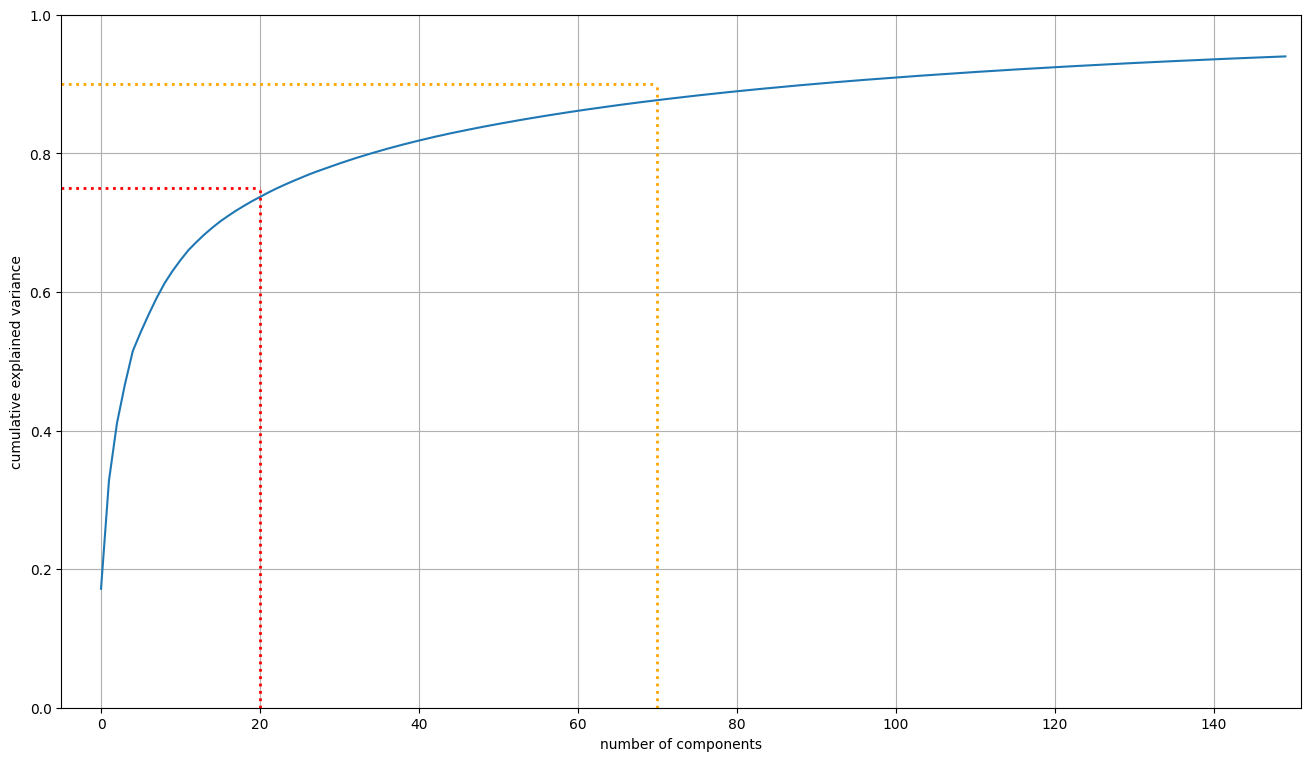

In [19]:
plt.figure(figsize=(16, 9))
# Plot the data
plt.plot(np.cumsum(pca.explained_variance_ratio_))
# Set labels
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# Display grid in the background
plt.grid()
# Set the limits for the axes
plt.xlim((-5, 151))
plt.ylim((0, 1))

# Add lines to the plot
plt.hlines(
    y=[.75, .9],
    xmin=[-5, -5],
    xmax=[20, 70],
    linestyles='dotted',
    colors=['red', 'orange'],
    linewidth=2
)
plt.vlines(
    x=[20, 70],
    ymin=[0, 0],
    ymax=[.75, .9],
    linestyles='dotted',
    colors=['red', 'orange'],
    linewidth=2
);

❓ What is the smallest number of components you need to keep to get _at least_ 80% of the variance?  
👉  Assign your answer to a variable named `minimal_pc_count`

In [20]:
minimal_pc_count = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.8) + 1
minimal_pc_count

36

## Classify Images (PCA as Feature Engineering)

It is time to use **PCA** as a tool for **supervised ML**  .

Here is your brief 👇

Given a picture of the face of a famous person among a selection, your model should be able to tell to whom the face belongs.  

Translating this brief into ML terms 👇
- Your samples are images
- Your features are their pixels
- Your target is a class among several (7)

❓ Cross-validate a model of your choice, suited for the classification task at hand    
👉 Record the time needed to train and evaluate your model

In [21]:
%time
model = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
X = faces.data
y = faces.target
cv = cross_validate(model, X, y, cv=10)

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
data_projected

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-1.619428,-1.507730,-0.037036,-0.357536,-0.483413,0.401034,-0.206893,0.894975,-0.271271,-0.212930,...,-0.010945,-0.437554,-0.110568,0.033983,-0.233376,-0.197830,-0.042355,-0.064914,-0.353076,-0.037923
1,2.160853,-3.241604,0.606053,0.876692,1.176245,-2.169051,-0.063054,1.268050,-0.021298,1.990511,...,-0.221913,-0.140069,0.313585,-0.126272,-0.003370,-0.232863,-0.187893,0.110420,0.000678,0.052564
2,-2.572261,-0.457799,-1.035993,-1.249724,0.264295,-0.127726,-0.411198,-1.043921,-0.420282,1.483854,...,0.206444,0.086660,-0.100770,0.129795,0.110394,0.005322,-0.251708,0.183777,0.046939,0.146746
3,0.441712,-2.345074,-0.197760,-2.339198,1.574509,0.724245,0.014996,1.450707,-0.659763,-0.763941,...,-0.102058,-0.198607,-0.059591,-0.083609,0.015585,0.103904,0.138479,-0.008322,-0.171552,-0.014820
4,4.013384,1.930254,2.679564,-0.628568,-0.274245,1.560862,-0.724098,-0.586559,-1.056079,-0.480919,...,0.251229,0.367610,0.032730,0.218743,-0.377655,0.114605,0.080417,0.129053,-0.350032,-0.262603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,-2.575238,-3.829735,-3.750360,2.063997,0.719955,-2.036755,0.088317,0.810859,-1.078327,0.758947,...,0.015418,-0.170469,-0.022235,0.146516,-0.109535,0.187296,0.161413,0.130464,0.336451,-0.156376
1284,1.533732,-1.680000,-3.250760,-2.547065,-2.857016,0.128607,0.179222,-1.407637,0.756005,1.072945,...,0.197290,-0.110951,-0.010657,0.170881,-0.132330,0.363603,0.103671,0.170264,-0.211636,0.123997
1285,3.755537,0.879406,0.335873,-0.779273,-0.746046,-0.830231,-0.603166,1.094075,-0.136574,0.829346,...,0.098370,-0.166762,0.030840,0.104413,0.022693,-0.226923,-0.084805,0.139782,0.219613,0.062038
1286,-3.708679,-0.507192,1.473879,1.620680,-0.361707,1.695732,1.409575,-0.583053,0.427692,-0.458241,...,0.400958,0.057600,-0.096077,-0.082408,0.083926,-0.012894,-0.036649,-0.060519,-0.165712,-0.000998


In [23]:
%time
cv_2 = cross_validate(model, np.array(data_projected), y, cv=10)

CPU times: total: 0 ns
Wall time: 0 ns


In [24]:
print(f"CV with X : {cv['test_score'].mean()}, CV with data_projected: {cv_2['test_score'].mean()}")

CV with X : 0.5155523255813954, CV with data_projected: 0.521015019379845


## Search for the Optimal Number of Components

*This time, the Machine Learning way: Grid Search*.

❓ Before proceeding, hold out 30% of your data as a test set  

👉 As usual, assign your split data to `X_train`, `X_test`, `y_train`, `y_test`  
👉 In your `train_test_split`, use `random_state=42` to compare results with your buddy

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

💡 A grid search calls for a pipeline  
❓ Use [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) to create a pipeline with two steps:
- A `PCA`, no need to choose the number of components now
- The [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) algorithm as an estimator

In [26]:
pipe = make_pipeline(PCA(), SVC())
pipe
pipe.get_params()

{'memory': None,
 'steps': [('pca', PCA()), ('svc', SVC())],
 'verbose': False,
 'pca': PCA(),
 'svc': SVC(),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

❓ Create a cross-validated grid search that uses your pipeline  
👉 Search only for the number of components for your `PCA` among these options: `[50, 100, 200, 300]`  

In [27]:
%time
grid_search = GridSearchCV(
    pipe, 
    param_grid={
        "pca__n_components": [50, 100, 200, 300]
    },
    cv=5,
    scoring="r2")
grid_search.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=5, estimator=Pipeline(steps=[('pca', PCA()), ('svc', SVC())]),
             param_grid={'pca__n_components': [50, 100, 200, 300]},
             scoring='r2')

❓ Print the [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) of your best model  
👉 Use the `best estimator` from your grid search to obtain predictions from **X_test**  
👉 Use these predictions against **y_test** to print your classification report

In [28]:
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('pca', PCA(n_components=100)), ('svc', SVC())])

In [29]:
y_pred = best_model.predict(X_test)
y_pred

array([3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 4, 1, 3,
       3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1,
       1, 1, 3, 3, 2, 3, 3, 3, 0, 3, 3, 2, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3,
       6, 4, 1, 3, 6, 6, 3, 3, 3, 2, 1, 6, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 6, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 1, 3, 1, 3, 3, 0, 3, 4, 3, 3, 1, 3, 6, 6,
       6, 3, 3, 6, 3, 3, 3, 6, 3, 2, 3, 1, 3, 6, 3, 3, 3, 1, 1, 1, 3, 3,
       3, 3, 1, 3, 3, 3, 6, 3, 4, 1, 3, 3, 5, 1, 3, 3, 3, 1, 3, 1, 3, 3,
       3, 2, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 6, 2, 3, 3,
       3, 3, 3, 2, 1, 1, 3, 3, 3, 3, 6, 3, 1, 3, 3, 3, 3, 3, 3, 2, 1, 3,
       3, 3, 1, 1, 1, 3, 3, 3, 6, 3, 3, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 6, 2, 1, 3, 2, 2, 3, 3, 1,
       3, 3, 3, 1, 3, 6, 1, 6, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1,
       3, 3, 3, 4, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3,

In [30]:
y_test

array([3, 3, 6, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 4, 1, 2,
       3, 2, 0, 1, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1,
       1, 1, 4, 3, 2, 3, 3, 3, 0, 3, 6, 2, 1, 3, 5, 3, 1, 1, 1, 4, 3, 5,
       6, 4, 1, 3, 5, 6, 3, 3, 3, 2, 1, 6, 4, 4, 3, 0, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 3, 4, 1, 5, 1, 1, 6, 6, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1,
       4, 1, 3, 3, 3, 1, 3, 4, 1, 3, 1, 3, 3, 0, 3, 4, 4, 3, 1, 1, 6, 6,
       6, 6, 2, 4, 3, 3, 1, 6, 2, 2, 5, 1, 3, 5, 1, 3, 6, 1, 5, 1, 1, 3,
       3, 3, 6, 0, 1, 3, 6, 5, 5, 1, 3, 5, 5, 1, 0, 3, 1, 1, 6, 1, 5, 6,
       3, 2, 2, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 6, 3, 3, 6,
       3, 6, 3, 2, 1, 2, 3, 3, 6, 2, 1, 0, 3, 5, 3, 3, 3, 3, 3, 0, 0, 1,
       3, 3, 1, 1, 6, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 6, 3, 3, 3, 3, 4,
       2, 4, 3, 0, 3, 3, 3, 6, 4, 3, 2, 6, 3, 4, 2, 1, 6, 2, 2, 3, 6, 1,
       3, 4, 3, 1, 4, 6, 1, 1, 3, 3, 6, 3, 6, 3, 3, 3, 1, 2, 3, 3, 1, 0,
       3, 3, 3, 4, 4, 3, 5, 1, 3, 0, 4, 1, 3, 4, 3,

In [31]:
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.28      0.43        18
           1       0.75      0.71      0.73        69
           2       0.86      0.56      0.68        34
           3       0.62      0.96      0.75       166
           4       0.90      0.29      0.44        31
           5       1.00      0.05      0.10        19
           6       0.68      0.38      0.49        50

    accuracy                           0.67       387
   macro avg       0.83      0.46      0.52       387
weighted avg       0.73      0.67      0.64       387



❓ How many components give the best score?  
👉 Assign the value to a variable named **best_n_components**

In [32]:
best_n_components = grid_search.best_params_["pca__n_components"]
best_n_components

100

## What about Scaling, Balancing and Tuning?

*The complete Machine Learning pipeline*

We focused extensively on PCA but there are 3 ML methods you can use to enhance your score:
- Scale your data before applying PCA
- Use some form of balancing as your classes are not balanced
- Grid search for optimal hyperparameters for your estimator

Let's do it and see how using `PCA` alongside the ML tricks we have seen so far will help us achieve a higher score

❓ Run the cell below to see both your baseline and base score obtained with only PCA + SVC

In [33]:
baseline = pd.Series(y).value_counts(normalize=True).max()
score_base = cross_validate(
    make_pipeline(
        PCA(n_components=best_n_components),
        SVC()
    ),
    X, y,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)['test_score'].mean()


print(f"""
    Accuracy scores:
    Baseline (frequency of most frequent class): {baseline: .2%}
    Base Model (PCA + SVC): {score_base:.2%}
""")


    Accuracy scores:
    Baseline (frequency of most frequent class):  41.15%
    Base Model (PCA + SVC): 64.67%



### Scaling

❓ Scale your data before reduction with a `PCA`  
👉 Build a pipeline that has 3 steps:
- Scaling with `StandardScaler`
- Reduction with `PCA` (use **best_n_components** from your earlier search)
- Prediction with `SVC` (keep all default arguments)

In [34]:
pipe_2 = make_pipeline(
    StandardScaler(),
    PCA(n_components=best_n_components),
    SVC()
)
pipe_2

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=100)), ('svc', SVC())])

In [35]:
pipe_2.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=100)), ('svc', SVC())])>

❓ Cross-validate your pipeline on the full **X** and **y** over 3 folds  
👉 Store the mean score in **score_scaling**  
👉 Check your new score

In [36]:
# YOUR CODE HERE
cv_3 = cross_validate(pipe_2, X, y, cv=3)
score_scaling = cv_3["test_score"].mean()
score_scaling

0.6840010119079887

### Balancing

❓ Check the spread of your target classes

In [37]:
spread = pd.Series(y).value_counts() / len(y) *100
spread

3    41.149068
1    18.322981
6    11.180124
2     9.394410
4     8.462733
0     5.978261
5     5.512422
Name: count, dtype: float64

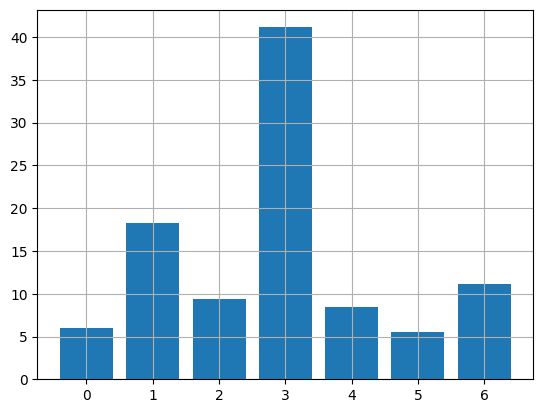

In [38]:
plt.bar(spread.index, spread.values)
plt.grid(True)

❓ Train another pipeline that takes into account your class imbalance  
👉 Check the [documentation of the SVC estimator](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)  
👉 Find and use the parameter that helps with the class imbalance in your SVC  
👉 Store the mean score in **score_balanced** and check your new score

In [39]:
pipe_balanced = make_pipeline(
    StandardScaler(),
    PCA(n_components=best_n_components),
    SVC(class_weight="balanced")
)

cv_4 = cross_validate(pipe_balanced, X, y, cv=3)
score_balanced = cv_4["test_score"].mean()
score_balanced

0.716598904970998

### Fine-Tuning

In [40]:
grid = {
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],
    'svc__gamma': [1e-4, 1e-3, 1e-2],
    'svc__C': [10, 1e2, 1e3]
}
search = GridSearchCV(
    pipe_balanced, 
    grid,
    cv=3,
    scoring='accuracy'
)
search.fit(X, y)
score_tuned = search.best_score_
round(score_tuned, 5)

0.81053

## (Optional) Reconstruction of an Original Image

👉 Study the cells below which reconstruct the image step by step without `inverse_transform`  

👉 We start by selecting a single image for the example

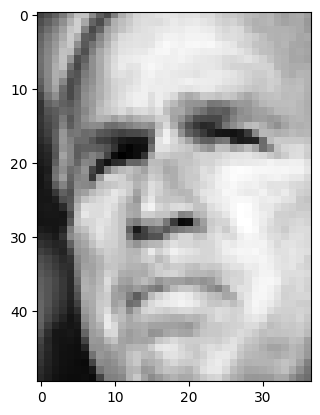

In [41]:
# Let's reconstruct the 13th image
image_original = faces.images[12];
image_compressed = data_projected[12];

plt.imshow(image_original, cmap='gray');

👉 We manually do the sum of multiplications $X\_reconstructed_{i} = \sum_{i=1}^{n\_components}{X_{projected_i} * W_i}$  
$W_i$ being the `i-th principal component`  

In [42]:
# We start the reconstruction from the mean of all images
image_reconstructed = pca.mean_.copy(); 
# Then, reconstruct the image by computing the sum of every 150 entries of its compressed representation, weighted by the corresponding principal components
reconstruction = list()
for i in range(pca.n_components_):
    image_reconstructed += pca.components_[i] * image_compressed[i]
    reconstruction.append(image_reconstructed.copy())

👉 We plot the reconstructed image alongside the original

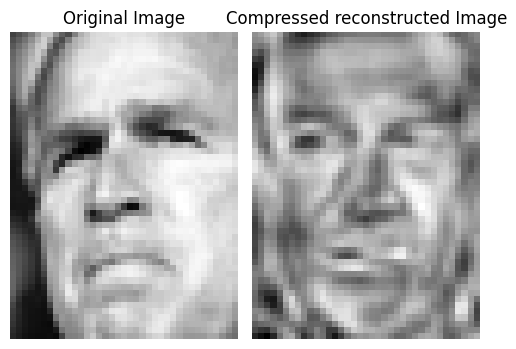

In [43]:
# Plot the original and the compressed image.
fig, ax = plt.subplots(1, 2, figsize = (5, 5))
# Original
ax[0].imshow(image_original, cmap='gray')
ax[0].set_title('Original Image')

# Reconstructed
ax[1].imshow(image_reconstructed.reshape(faces.images[0].shape), cmap='gray')
ax[1].set_title('Compressed reconstructed Image')

for ax in fig.axes:
    ax.axis('off')

plt.tight_layout()

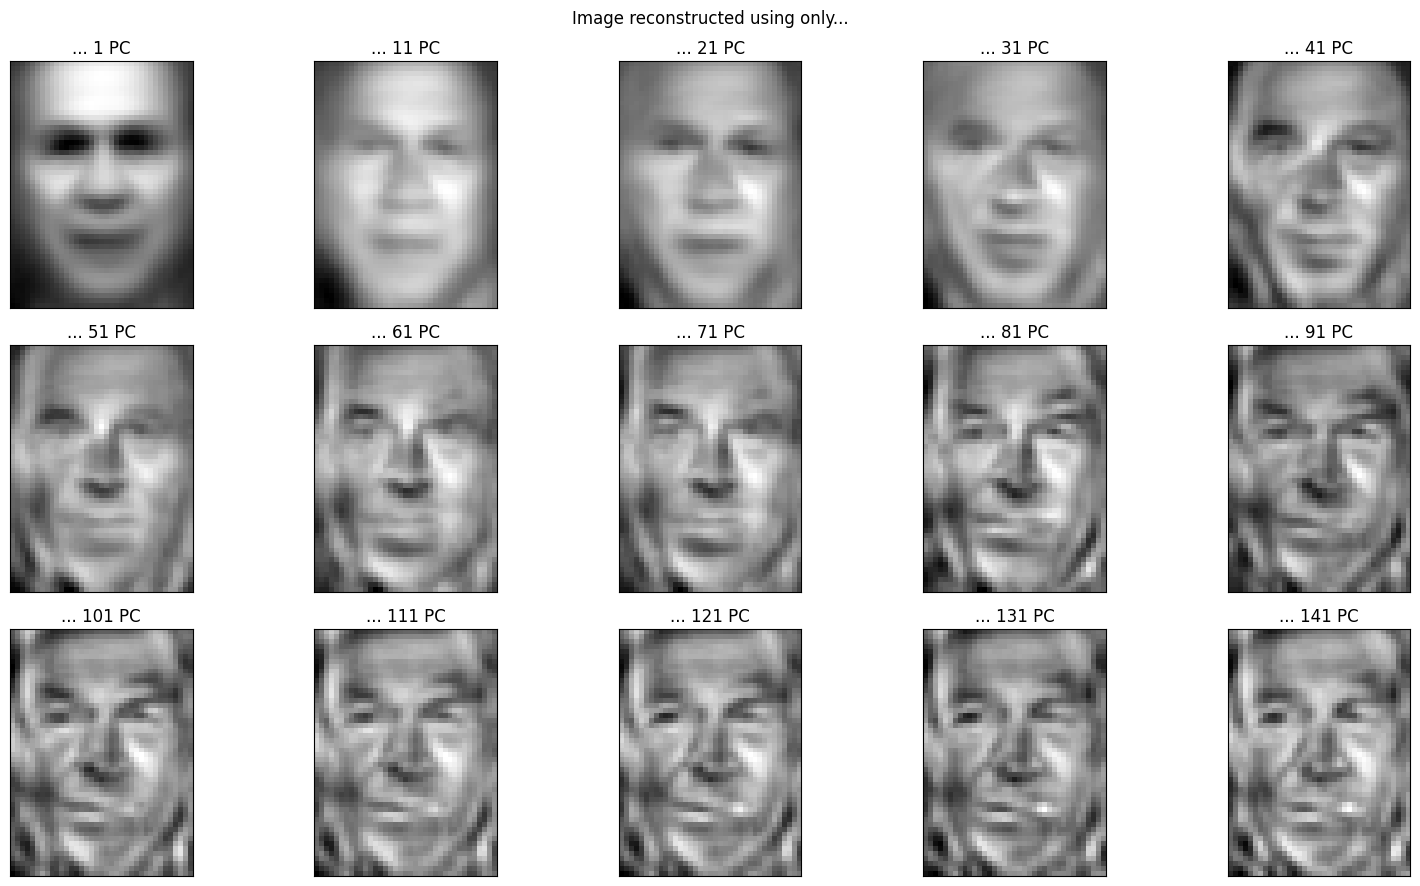

In [44]:
# Plot several images at different steps of reconstruction
n_rows, n_cols = 3, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 9))
plt.suptitle('Image reconstructed using only...')

for i in range(n_rows * n_cols):
    ax = axs[i // n_cols, i % n_cols]
    ax.set_title(f'... {i * 10 + 1} PC', size=12)
    ax.set_xticks(()), ax.set_yticks(())
    ax.imshow(reconstruction[i * 10].reshape(50, 37), cmap='gray')

plt.tight_layout()